## Time Series Analysis using PyMC3 and statsmodels

### Based on https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_pymc3.html

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import statsmodels.api as sm
import theano
import theano.tensor as tt
from pandas.plotting import register_matplotlib_converters
# from pandas_datareader.data import DataReader

plt.style.use("seaborn")
register_matplotlib_converters()

#### It turned out that installing pandas_datareader requires libxml2, which needs to be installed as a part of XCode Command Line Tools by "xcode-select --install", which takes a few hours. Thus, decided to use solar radiation data instead.

In [3]:
from agrivoltaics_supply_side_management.solar_irradiation.clearsky import get_clearsky

In [4]:
vancouver_data = pd.read_csv("../data/weather_data/vancouver_bc_canada_49.263566_-123.138572_psm3_60_tmy.csv",
                             header=[2])

In [5]:
vancouver_data['Datetime'] = pd.to_datetime(vancouver_data[['Year', 'Month', 'Day', 'Hour', 'Minute']])

In [6]:
vancouver_data.set_index('Datetime', inplace=True)

In [7]:
vancouver_data.index = vancouver_data.index.tz_localize('Canada/Pacific', 
                                                        ambiguous='NaT', nonexistent='shift_forward')

In [8]:
vancouver_data.drop(columns=['Year', 'Month', 'Day', 'Hour', 'Minute'], inplace=True)

In [9]:
vancouver_data_ghi = vancouver_data.GHI

In [10]:
vancouver_data_ghi_0717 = vancouver_data_ghi[vancouver_data_ghi.index.strftime('%m-%d')=='07-17']

<AxesSubplot:xlabel='Datetime'>

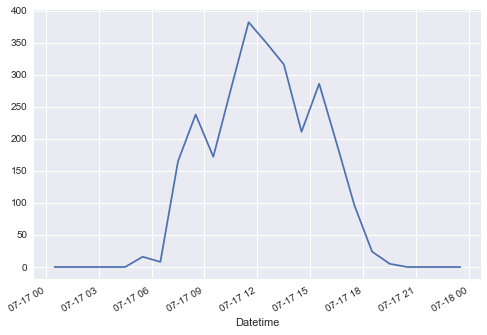

In [11]:
vancouver_data_ghi_0717.plot()

In [12]:
vancouver_clearsky_ghi_0717 = get_clearsky(49.263566, -123.138572, 
                                           'Canada/Pacific', vancouver_data_ghi_0717.index,
                                           location_name='Vancouver, BC, Canada')['ghi']

In [13]:
vancouver_clearsky_ghi_scaled_0717 = vancouver_clearsky_ghi_0717 * (
    vancouver_data_ghi_0717.max() / vancouver_clearsky_ghi_0717.max())

In [14]:
vancouver_data_data_residual_0717 = vancouver_data_ghi_0717 - vancouver_clearsky_ghi_scaled_0717

<AxesSubplot:xlabel='Datetime'>

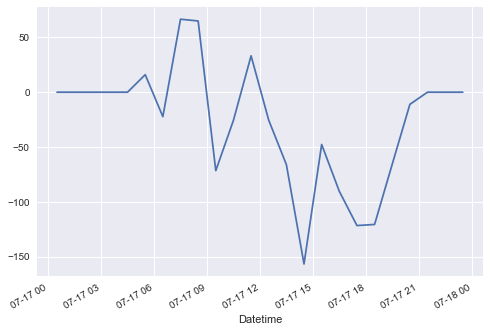

In [15]:
vancouver_data_data_residual_0717.plot()

#### Fit the model with maximum likelihood

In [16]:
sarimax_model = sm.tsa.statespace.SARIMAX(vancouver_data_data_residual_0717, order=(1, 0, 1))

/Users/tadatoshi/.pyenv/versions/3.10.5/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/tadatoshi/.pyenv/versions/3.10.5/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


In [17]:
sarimax_result_mle = sarimax_model.fit(disp=False)

In [18]:
sarimax_result_mle.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   24
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -127.071
Date:                Sun, 09 Oct 2022   AIC                            260.143
Time:                        19:50:09   BIC                            263.677
Sample:                    07-17-2002   HQIC                           261.080
                         - 07-17-2002                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7555      0.275      2.751      0.006       0.217       1.294
ma.L1         -0.2738      0.419     -0.653      0.514      -1.096       0.548
sigma2      2280.6381    579.538      3.935      0.000    1144.764    3416.512
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 1.98
Prob(Q):                              0.86   Prob(JB):                         0.37
Heteroskedasticity (H):               1.58   Skew:                            -0.70
Prob(H) (two-sided):                  0.53   Kurtosis:                         3.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
predict_sarimax_mle = sarimax_result_mle.get_prediction()

In [20]:
predict_sarimax_mle_ci = predict_sarimax_mle.conf_int()

In [21]:
predict_sarimax_mle_ci

,lower y,upper y
2002-07-17 00:30:00-07:00,-116.178865,116.178865
2002-07-17 01:30:00-07:00,-94.823686,94.823686
2002-07-17 02:30:00-07:00,-93.690040,93.690040
2002-07-17 03:30:00-07:00,-93.606828,93.606828
2002-07-17 04:30:00-07:00,-93.600598,93.600598
2002-07-17 05:30:00-07:00,-93.600131,93.600131
2002-07-17 06:30:00-07:00,-85.903648,101.296543
2002-07-17 07:30:00-07:00,-102.239888,84.960298
2002-07-17 08:30:00-07:00,-63.907932,123.292254
2002-07-17 09:30:00-07:00,-54.181947,133.018239


In [22]:
lower_sarimax = predict_sarimax_mle_ci["lower y"]

In [23]:
upper_sarimax = predict_sarimax_mle_ci["upper y"]

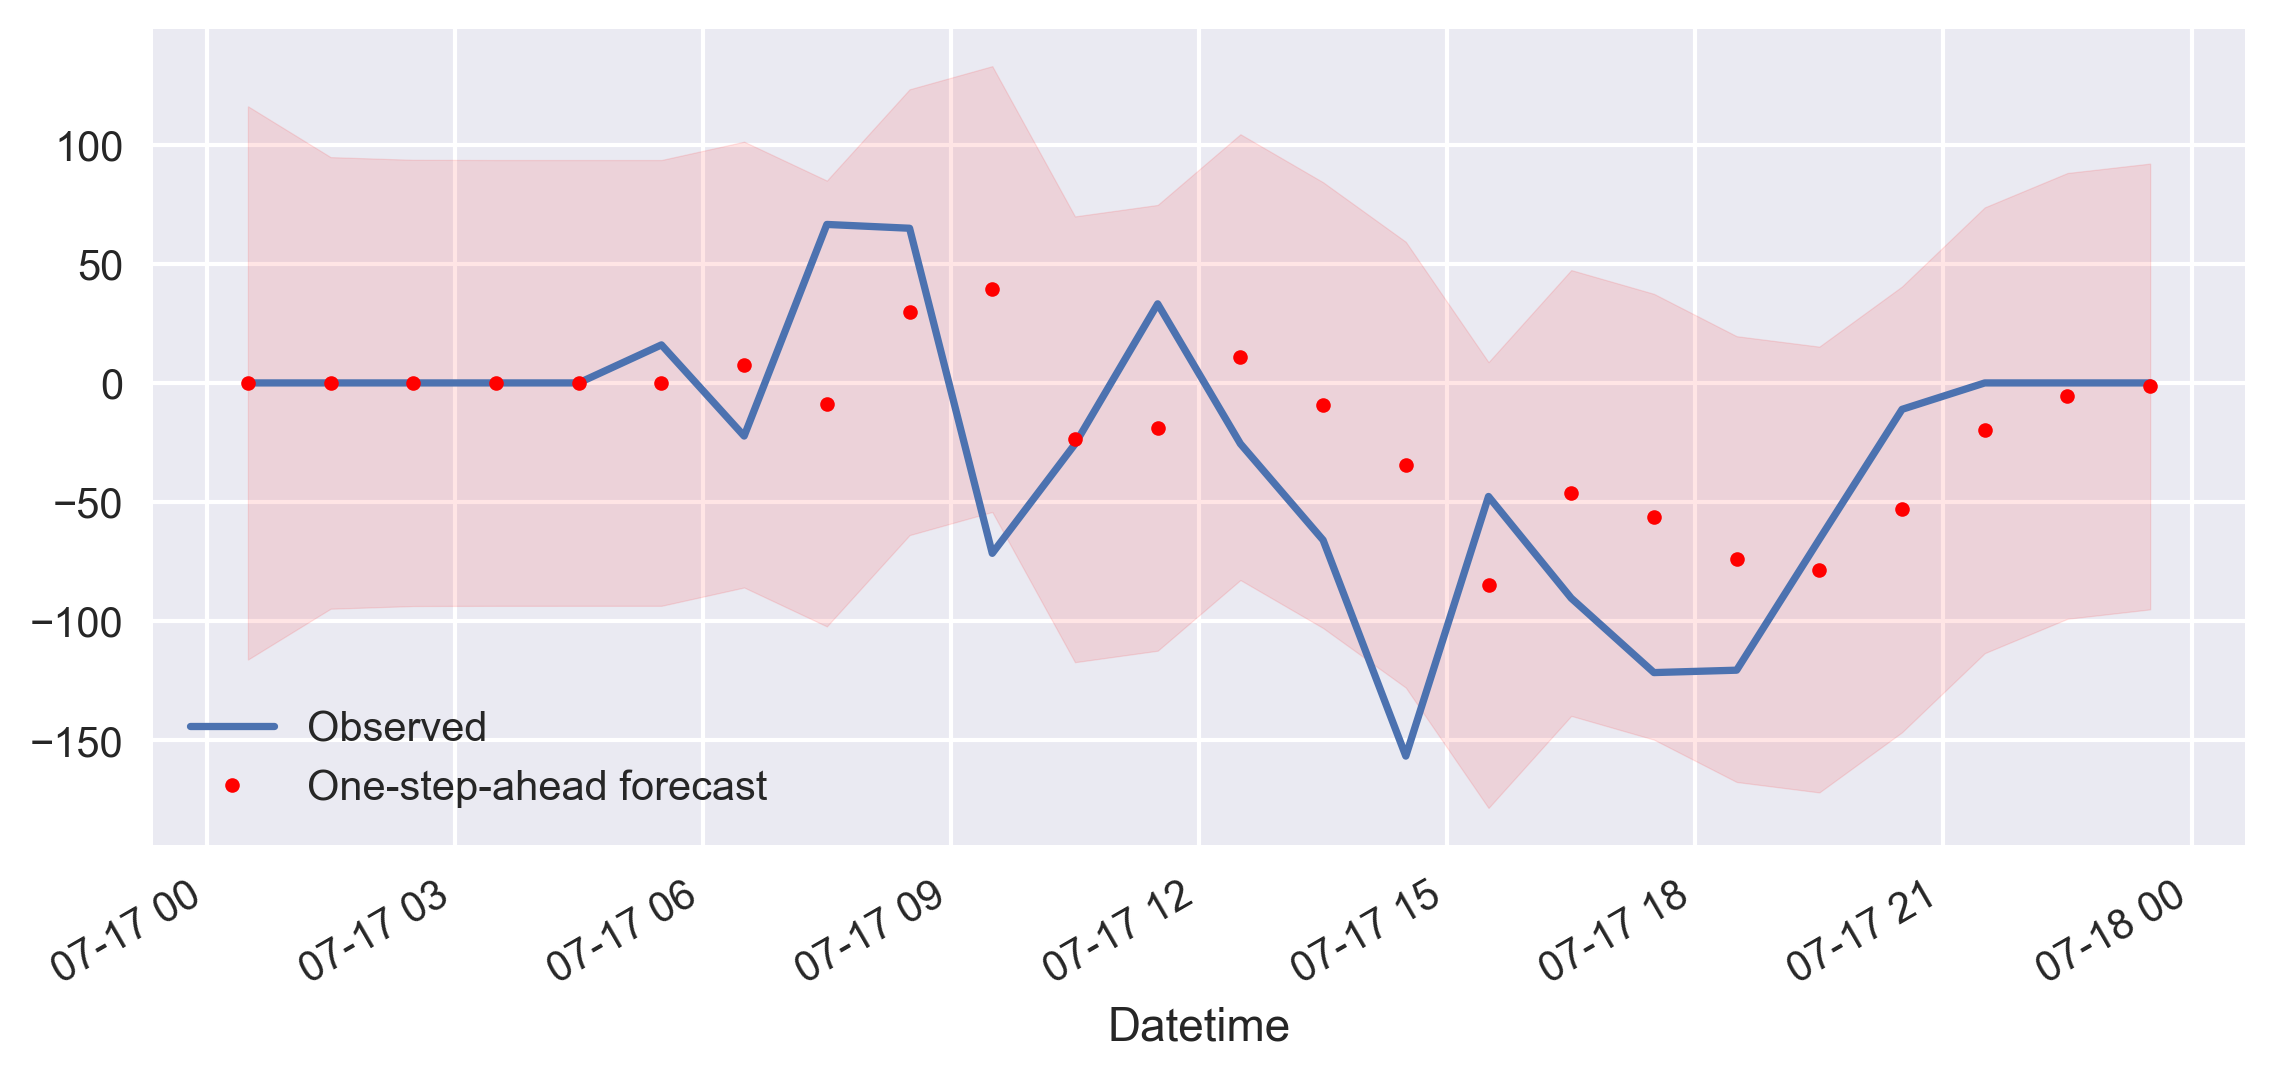

In [24]:
fig, ax = plt.subplots(figsize=(9, 4), dpi=300)
vancouver_data_data_residual_0717.plot(ax=ax, style="-", label="Observed")
# Plot predictions
predict_sarimax_mle.predicted_mean.plot(ax=ax, style="r.", label="One-step-ahead forecast")
ax.fill_between(predict_sarimax_mle_ci.index, lower_sarimax, upper_sarimax, color="r", alpha=0.1)
ax.legend(loc="lower left")
plt.show()

#### Bayesian estimation with NUTS

In [25]:
# Set sampling params
ndraws = 3000  # number of draws from the distribution
nburn = 600  # number of "burn-in points" (which will be discarded)

In [26]:
from statsmodels_to_pymc3_tensor import Loglike

In [27]:
# Construct an instance of the Theano wrapper defined above, which
# will allow PyMC3 to compute the likelihood and Jacobian in a way
# that it can make use of. 
loglike_sarimax = Loglike(sarimax_model)

In [28]:
with pm.Model() as m:
    # Priors
    ar_l1_sarimax = pm.Uniform("ar.l1", -0.99, 0.99)
    ma_l1_sarimax = pm.Uniform("ma.l1", -0.99, 0.99)
    sigma2_sarimax = pm.InverseGamma("sigma2", 2, 4)
    
    # convert variables to tensor vectors
    theta_sarimax = tt.as_tensor_variable([ar_l1_sarimax, ma_l1_sarimax, sigma2_sarimax])
    
    # use a DensityDist (use a lamdba function to "call" the Op)
    pm.DensityDist("likelihood", loglike_sarimax, observed=theta_sarimax)
    
    # Draw samples
    trace_sarimax = pm.sample(
        ndraws,
        tune=nburn,
        return_inferencedata=True,
        cores=1,
        compute_convergence_checks=False,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma2, ma.l1, ar.l1]


/Users/tadatoshi/.pyenv/versions/3.10.5/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tools/numdiff.py:246: RuntimeWarning: invalid value encountered in multiply
  increments = np.identity(n) * 1j * epsilon


Sampling 2 chains for 600 tune and 3_000 draw iterations (1_200 + 6_000 draws total) took 116 seconds.


/Users/tadatoshi/.pyenv/versions/3.10.5/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/traceplot.py:214: UserWarning: A valid var_name should be provided, found {'ma.L1', 'ar.L1'} expected from {'sigma2', 'ma.l1', 'ar.l1'}
  warnings.warn(


<Figure size 576x396 with 0 Axes>

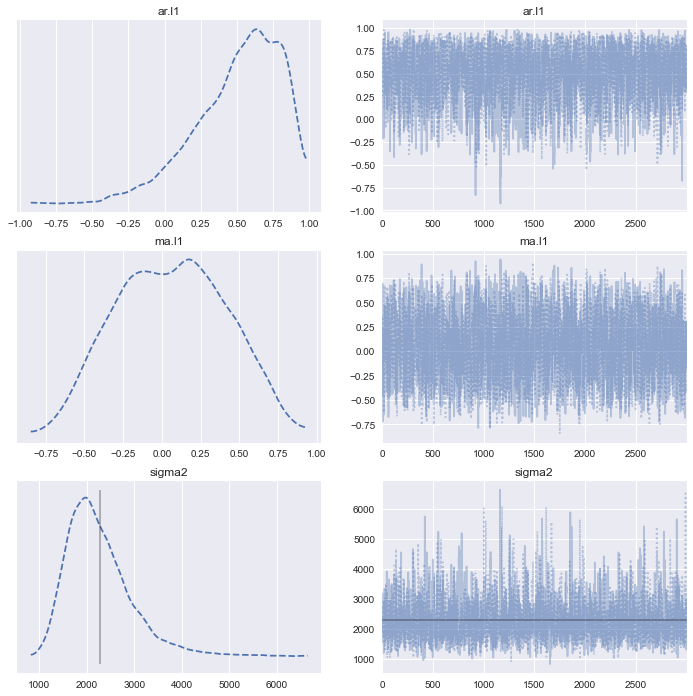

In [29]:
plt.tight_layout()
# Note: the syntax here for the lines argument is required for
# PyMC3 versions >= 3.7
# For version <= 3.6 you can use lines=dict(res_mle.params) instead
_ = pm.plot_trace(
    trace_sarimax,
    lines=[(k, {}, [v]) for k, v in dict(sarimax_result_mle.params).items()],
    combined=True,
    figsize=(12, 12),
)

In [30]:
pm.summary(trace_sarimax)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ar.l1,0.510,0.293,-0.024,0.964,0.006,0.004,2213.0,2556.0,1.0
ma.l1,0.064,0.346,-0.531,0.702,0.007,0.005,2412.0,2223.0,1.0
sigma2,2260.176,693.632,1169.519,3549.127,14.004,10.169,2596.0,2563.0,1.0


#### Application of Bayesian estimates of parameters

In [31]:
# Retrieve the posterior means
params_sarimax = pm.summary(trace_sarimax)["mean"].values

In [32]:
params_sarimax

array([5.100000e-01, 6.400000e-02, 2.260176e+03])

In [34]:
# Construct results using these posterior means as parameter values
result_bayes_sarimax = sarimax_model.smooth(params_sarimax)

In [35]:
predict_bayes_sarimax = result_bayes_sarimax.get_prediction()

In [36]:
predict_bayes_sarimax

In [37]:
predict_bayes_sarimax_ci = predict_bayes_sarimax.conf_int()

In [38]:
predict_bayes_sarimax_ci

,lower y,upper y
2002-07-17 00:30:00-07:00,-112.020607,112.020607
2002-07-17 01:30:00-07:00,-93.238029,93.238029
2002-07-17 02:30:00-07:00,-93.179493,93.179493
2002-07-17 03:30:00-07:00,-93.179253,93.179253
2002-07-17 04:30:00-07:00,-93.179252,93.179252
2002-07-17 05:30:00-07:00,-93.179252,93.179252
2002-07-17 06:30:00-07:00,-84.007875,102.350629
2002-07-17 07:30:00-07:00,-106.573274,79.785231
2002-07-17 08:30:00-07:00,-54.120338,132.238166
2002-07-17 09:30:00-07:00,-58.396151,127.962353


In [39]:
lower_bayes_sarimax = predict_bayes_sarimax_ci["lower y"]
upper_bayes_sarimax = predict_bayes_sarimax_ci["upper y"]

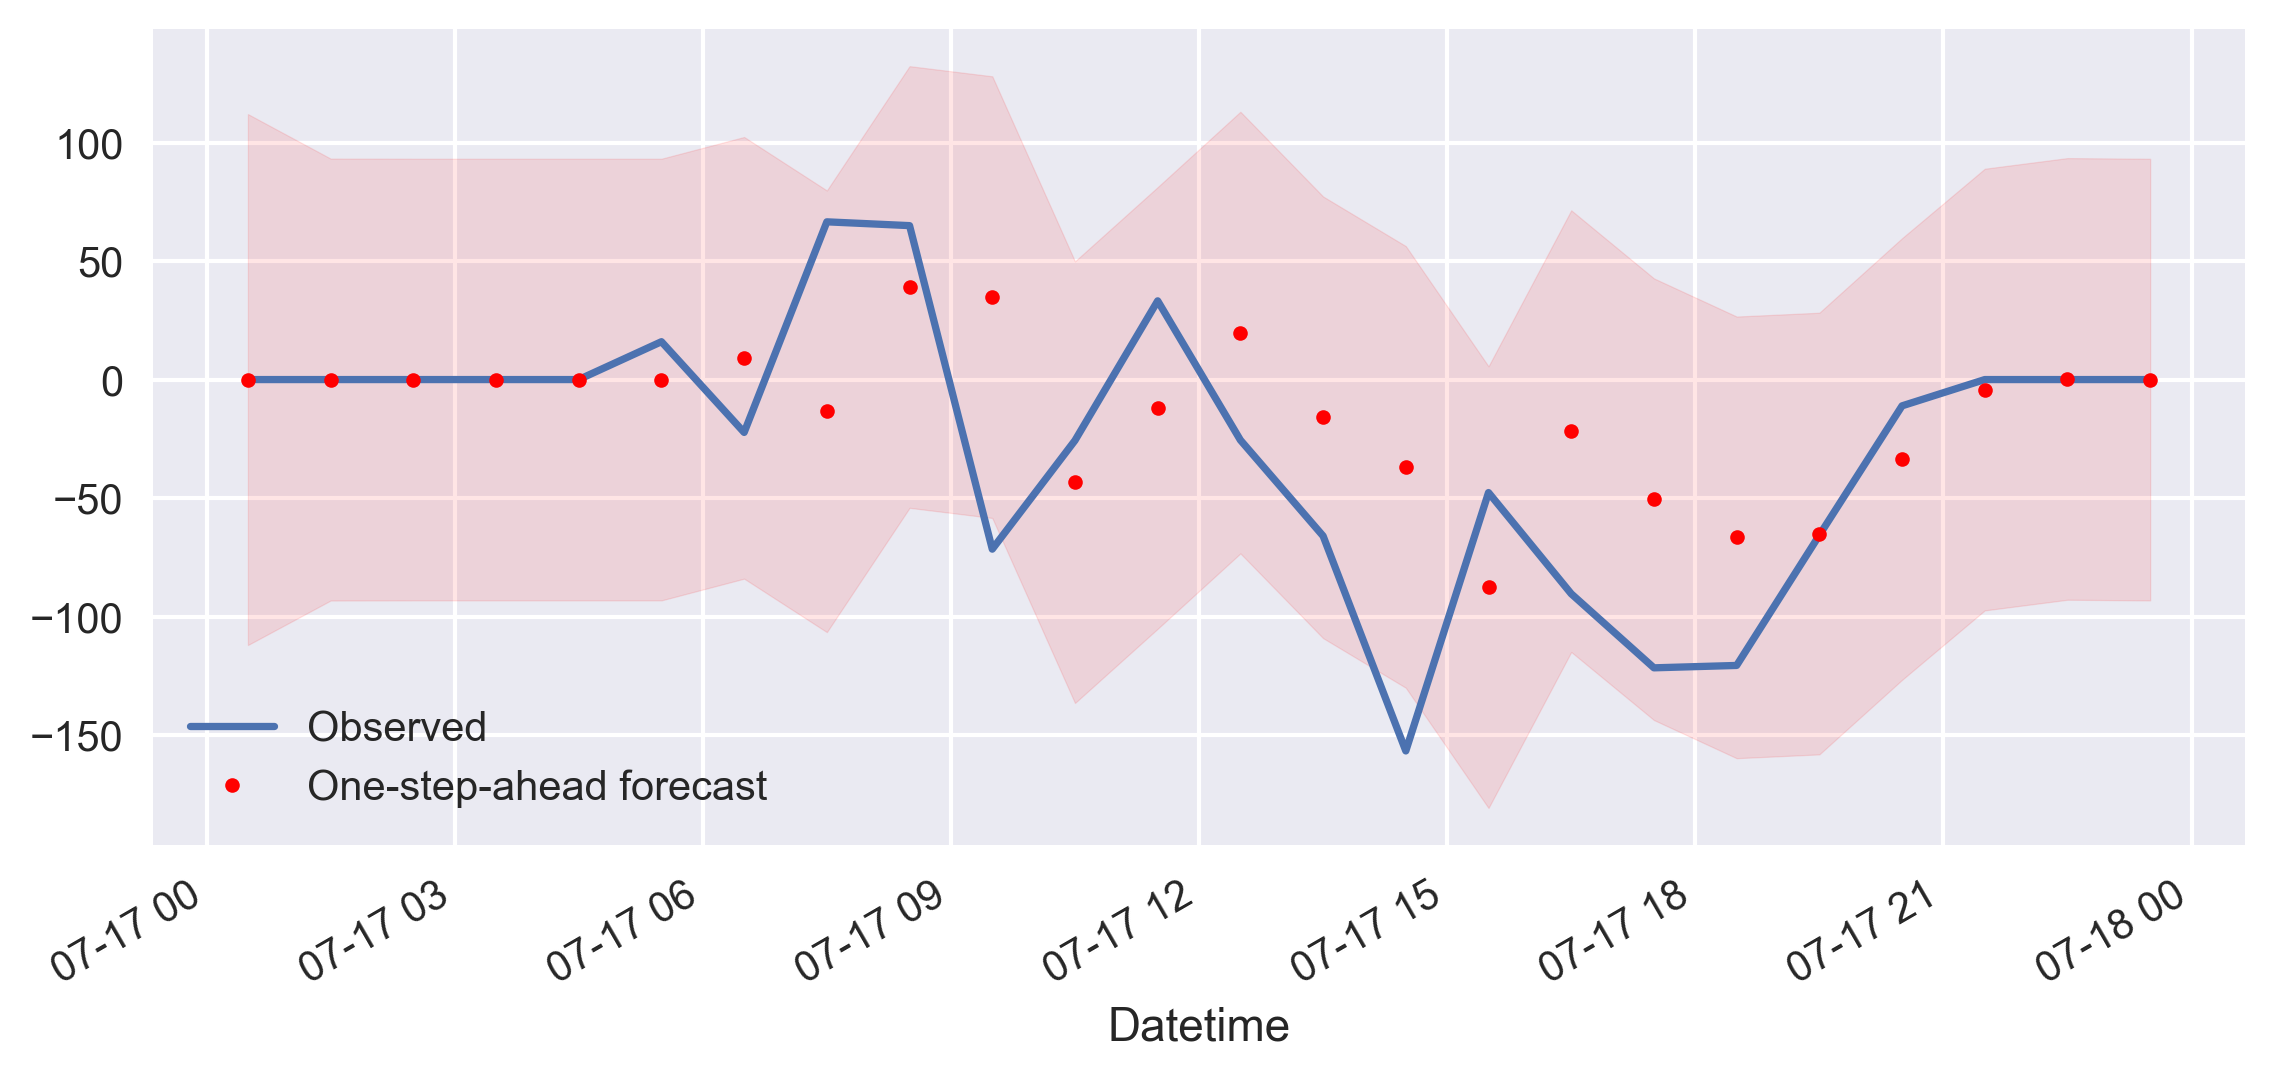

In [40]:
# Graph
fig, ax = plt.subplots(figsize=(9, 4), dpi=300)

# Plot data points
vancouver_data_data_residual_0717.plot(ax=ax, style="-", label="Observed")

# Plot predictions
predict_bayes_sarimax.predicted_mean.plot(ax=ax, style="r.", label="One-step-ahead forecast")
ax.fill_between(predict_bayes_sarimax_ci.index, lower_bayes_sarimax, upper_bayes_sarimax, color="r", alpha=0.1)
ax.legend(loc="lower left")
plt.show()

### Different model - Application to UnobservedComponents models

In [41]:
# Construct the model instance
model_uc = sm.tsa.UnobservedComponents(vancouver_data_data_residual_0717, "rwalk", autoregressive=1)

/Users/tadatoshi/.pyenv/versions/3.10.5/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


In [42]:
# Fit the model via maximum likelihood
result_uc_mle = model_uc.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.12080D+00    |proj g|=  1.39432D-02

At iterate    5    f=  5.11944D+00    |proj g|=  1.38964D-02

At iterate   10    f=  5.11359D+00    |proj g|=  4.03968D-04

At iterate   15    f=  5.11337D+00    |proj g|=  8.59282D-03

At iterate   20    f=  5.10909D+00    |proj g|=  2.01180D-02

At iterate   25    f=  5.10668D+00    |proj g|=  4.96367D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     30      1     0     0   

In [43]:
result_uc_mle

In [44]:
result_uc_mle.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                      y   No. Observations:                   24
Model:                    random walk   Log Likelihood                -122.560
                              + AR(1)   AIC                            251.121
Date:                Sun, 09 Oct 2022   BIC                            254.527
Time:                        19:53:21   HQIC                           251.977
Sample:                    07-17-2002                                         
                         - 07-17-2002                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
sigma2.level  1.326e-06    440.719   3.01e-09      1.000    -863.793     863.793
sigma2.ar     2284.7576   1015.268      2.250      0.024     294.868    4274.647
ar.L1            0.5759      0.315      1.830      0.067      -0.041       1.193
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 1.48
Prob(Q):                              0.80   Prob(JB):                         0.48
Heteroskedasticity (H):               1.35   Skew:                            -0.62
Prob(H) (two-sided):                  0.68   Kurtosis:                         2.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
# Here we follow the same procedure as above, but now we instantiate the
# Theano wrapper `Loglike` with the UC model instance instead of the
# SARIMAX model instance
loglike_uc = Loglike(model_uc)

In [46]:
with pm.Model():
    # Priors
    sigma2level_uc = pm.InverseGamma("sigma2.level", 1, 1)
    sigma2ar_uc = pm.InverseGamma("sigma2.ar", 1, 1)
    ar_l1_uc = pm.Uniform("ar.l1", -0.99, 0.99)

    # convert variables to tensor vectors
    theta_uc = tt.as_tensor_variable([sigma2level_uc, sigma2ar_uc, ar_l1_uc])

    # use a DensityDist (use a lamdba function to "call" the Op)
    pm.DensityDist("likelihood", loglike_uc, observed=theta_uc)
    
    # Draw samples
    trace_uc = pm.sample(
        ndraws,
        tune=nburn,
        return_inferencedata=True,
        cores=1,
        compute_convergence_checks=False,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ar.l1, sigma2.ar, sigma2.level]


/Users/tadatoshi/.pyenv/versions/3.10.5/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tools/numdiff.py:246: RuntimeWarning: invalid value encountered in multiply
  increments = np.identity(n) * 1j * epsilon
Sampling 2 chains for 600 tune and 3_000 draw iterations (1_200 + 6_000 draws total) took 78 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


/Users/tadatoshi/.pyenv/versions/3.10.5/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/traceplot.py:214: UserWarning: A valid var_name should be provided, found {'ar.L1'} expected from {'sigma2.ar', 'sigma2.level', 'ar.l1'}
  warnings.warn(


<Figure size 576x396 with 0 Axes>

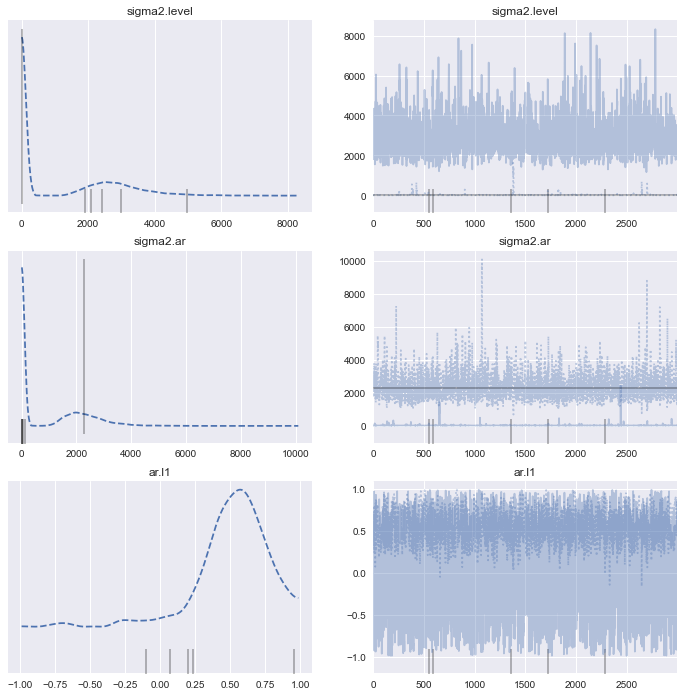

In [47]:
plt.tight_layout()
# Note: the syntax here for the lines argument is required for
# PyMC3 versions >= 3.7
# For version <= 3.6 you can use lines=dict(res_mle.params) instead
_ = pm.plot_trace(
    trace_uc,
    lines=[(k, {}, [v]) for k, v in dict(result_uc_mle.params).items()],
    combined=True,
    figsize=(12, 12),
)

In [48]:
pm.summary(trace_uc)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma2.level,1475.103,1609.632,0.115,3965.413,1054.461,866.072,3.0,54.0,1.83
sigma2.ar,1189.156,1313.690,0.157,3202.918,850.286,695.367,3.0,61.0,1.83
ar.l1,0.291,0.499,-0.731,0.989,0.199,0.148,10.0,59.0,1.24


In [49]:
# Retrieve the posterior means
params_uc = pm.summary(trace_uc)["mean"].values

In [50]:
params_uc

array([1.475103e+03, 1.189156e+03, 2.910000e-01])

In [51]:
# Construct results using these posterior means as parameter values
result_uc_bayes = model_uc.smooth(params_uc)

In [52]:
result_uc_bayes.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                      y   No. Observations:                   24
Model:                    random walk   Log Likelihood                -123.391
                              + AR(1)   AIC                            252.782
Date:                Sun, 09 Oct 2022   BIC                            256.189
Time:                        19:54:49   HQIC                           253.639
Sample:                    07-17-2002                                         
                         - 07-17-2002                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
sigma2.level  1475.1030   2672.672      0.552      0.581   -3763.237    6713.443
sigma2.ar     1189.1560   2565.308      0.464      0.643   -3838.755    6217.067
ar.L1            0.2910      1.444      0.201      0.840      -2.540       3.122
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):                 1.38
Prob(Q):                              0.64   Prob(JB):                         0.50
Heteroskedasticity (H):               1.19   Skew:                            -0.58
Prob(H) (two-sided):                  0.81   Kurtosis:                         3.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

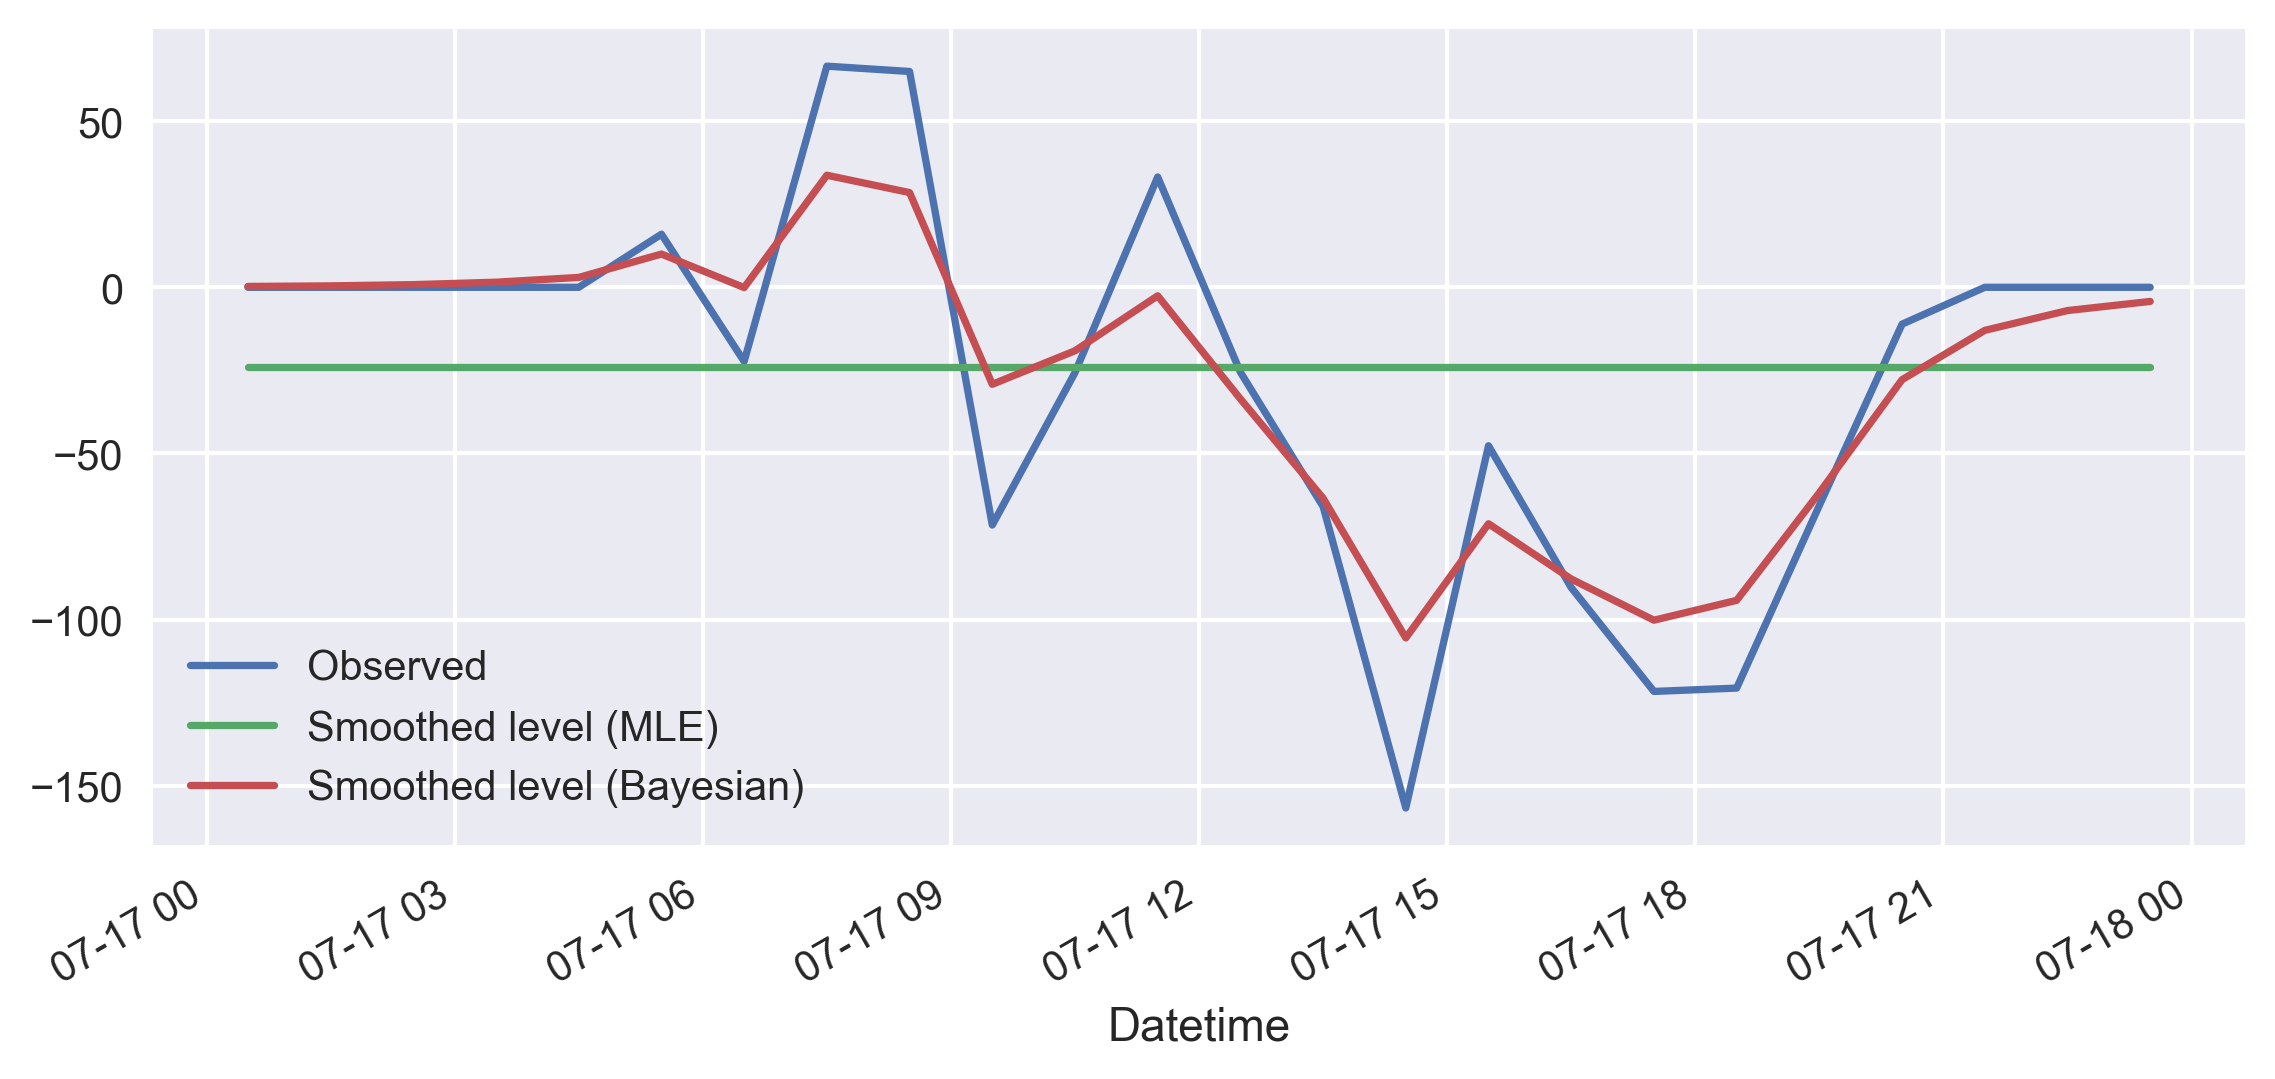

In [53]:
# Graph
fig, ax = plt.subplots(figsize=(9, 4), dpi=300)

# Plot data points
vancouver_data_data_residual_0717.plot(ax=ax, style="-", label="Observed")

# Plot estimate of the level term
result_uc_mle.states.smoothed["level"].plot(ax=ax, label="Smoothed level (MLE)")
result_uc_bayes.states.smoothed["level"].plot(ax=ax, label="Smoothed level (Bayesian)")

ax.legend(loc="lower left");